# Building an RL Agent to book flights on the web

In [ ]:
!wget -q --show-progress https://github.com/RecoHut-Projects/drl-recsys/raw/S990517/tools/webgym.zip
!unzip webgym.zip

In [ ]:
!pip install selenium
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-browser amd64 95.0.4638.69-0ubuntu0.18.04.1 [83.6 MB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-browser-l10n all 95.0.4638.69-0ubuntu0.18.04.1 [4,249 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-chromedriver amd64 95.0.4638.69-0ubuntu0.18.04.1 [4,986 kB]
Fetched 94.0 MB in 6s (16.2 MB/s)
Selecting previously unselected package chromium-codecs-ffmpeg-extra.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../chromium-codecs-ffmpeg-extra_95.0.4638.69-0ubuntu0.18.04.1_amd64.deb ...
Unpacking chromium-codecs-ffmpeg-extra (95.0.4638.69-0ubuntu0.18.04.1) ...
Selecting previously unselected package chromium-browser.
Preparing to unpack .../chromium-browser_95.0.4638.69-0ubuntu0.18.04.1_amd64.deb ...
Unpacking chromium-browser (95.0.4638.69-0ubuntu0.18.04.1) ...
Selecting previously unselected package

In [ ]:
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

In [ ]:
import webgym

In [ ]:
import argparse
import os
import random
from collections import deque
from datetime import datetime

import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    Input,
    Lambda,
    MaxPool2D,
)

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [ ]:
tf.keras.backend.set_floatx("float64")

In [ ]:
parser = argparse.ArgumentParser(prog="TFRL-Flight-Booking-Agent")
parser.add_argument("--env", default="MiniWoBBookFlightVisualEnv-v0")
parser.add_argument("--update-freq", type=int, default=16)
parser.add_argument("--epochs", type=int, default=3)
parser.add_argument("--actor-lr", type=float, default=1e-4)
parser.add_argument("--critic-lr", type=float, default=1e-4)
parser.add_argument("--clip-ratio", type=float, default=0.1)
parser.add_argument("--gae-lambda", type=float, default=0.95)
parser.add_argument("--gamma", type=float, default=0.99)
parser.add_argument("--logdir", default="logs")

args = parser.parse_args([])
logdir = os.path.join(
    args.logdir, parser.prog, args.env, datetime.now().strftime("%Y%m%d-%H%M%S")
)
print(f"Saving training logs to:{logdir}")
writer = tf.summary.create_file_writer(logdir)

Saving training logs to:logs/TFRL-Flight-Booking-Agent/MiniWoBBookFlightVisualEnv-v0/20211203-060108


In [ ]:
class Actor:
    def __init__(self, state_dim, action_dim, action_bound, std_bound):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action_bound = np.array(action_bound)
        self.std_bound = std_bound
        self.weight_initializer = tf.keras.initializers.he_normal()
        self.eps = 1e-5
        self.model = self.nn_model()
        self.model.summary()  # Print a summary of the Actor model
        self.opt = tf.keras.optimizers.Nadam(args.actor_lr)

    def nn_model(self):
        obs_input = Input(self.state_dim)
        conv1 = Conv2D(
            filters=64,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="same",
            input_shape=self.state_dim,
            data_format="channels_last",
            activation="relu",
        )(obs_input)
        pool1 = MaxPool2D(pool_size=(3, 3), strides=1)(conv1)
        conv2 = Conv2D(
            filters=32,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="valid",
            activation="relu",
        )(pool1)
        pool2 = MaxPool2D(pool_size=(3, 3), strides=1)(conv2)
        conv3 = Conv2D(
            filters=16,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="valid",
            activation="relu",
        )(pool2)
        pool3 = MaxPool2D(pool_size=(3, 3), strides=1)(conv3)
        conv4 = Conv2D(
            filters=8,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="valid",
            activation="relu",
        )(pool3)
        pool4 = MaxPool2D(pool_size=(3, 3), strides=1)(conv4)
        flat = Flatten()(pool4)
        dense1 = Dense(
            16, activation="relu", kernel_initializer=self.weight_initializer
        )(flat)
        dropout1 = Dropout(0.3)(dense1)
        dense2 = Dense(
            8, activation="relu", kernel_initializer=self.weight_initializer
        )(dropout1)
        dropout2 = Dropout(0.3)(dense2)
        # action_dim[0] = 2
        output_val = Dense(
            self.action_dim[0],
            activation="relu",
            kernel_initializer=self.weight_initializer,
        )(dropout2)
        # Scale & clip x[i] to be in range [0, action_bound[i]]
        mu_output = Lambda(
            lambda x: tf.clip_by_value(x * self.action_bound, 1e-9, self.action_bound)
        )(output_val)
        std_output_1 = Dense(
            self.action_dim[0],
            activation="softplus",
            kernel_initializer=self.weight_initializer,
        )(dropout2)
        std_output = Lambda(
            lambda x: tf.clip_by_value(
                x * self.action_bound, 1e-9, self.action_bound / 2
            )
        )(std_output_1)
        return tf.keras.models.Model(
            inputs=obs_input, outputs=[mu_output, std_output], name="Actor"
        )

    def get_action(self, state):
        # Convert [Image] to np.array(np.adarray)
        state_np = np.array([np.array(s) for s in state])
        if len(state_np.shape) == 3:
            # Convert (w, h, c) to (1, w, h, c)
            state_np = np.expand_dims(state_np, 0)
        mu, std = self.model.predict(state_np)
        action = np.random.normal(mu[0], std[0] + self.eps, size=self.action_dim).astype(
            "int"
        )
        # Clip action to be between 0 and max obs screen size
        action = np.clip(action, 0, self.action_bound)
        # 1 Action per instance of env; Env expects: (num_instances, actions)
        action = (action,)
        log_policy = self.log_pdf(mu, std, action)
        return log_policy, action

    def log_pdf(self, mu, std, action):
        std = tf.clip_by_value(std, self.std_bound[0], self.std_bound[1])
        var = std ** 2
        log_policy_pdf = -0.5 * (action - mu) ** 2 / var - 0.5 * tf.math.log(
            var * 2 * np.pi
        )
        return tf.reduce_sum(log_policy_pdf, 1, keepdims=True)

    def compute_loss(self, log_old_policy, log_new_policy, actions, gaes):
        # Avoid INF in exp by setting 80 as the upper bound since,
        # tf.exp(x) for x>88 yeilds NaN (float32)
        ratio = tf.exp(
            tf.minimum(log_new_policy - tf.stop_gradient(log_old_policy), 80)
        )
        gaes = tf.stop_gradient(gaes)
        clipped_ratio = tf.clip_by_value(
            ratio, 1.0 - args.clip_ratio, 1.0 + args.clip_ratio
        )
        surrogate = -tf.minimum(ratio * gaes, clipped_ratio * gaes)
        return tf.reduce_mean(surrogate)

    def train(self, log_old_policy, states, actions, gaes):
        with tf.GradientTape() as tape:
            mu, std = self.model(states, training=True)
            log_new_policy = self.log_pdf(mu, std, actions)
            loss = self.compute_loss(log_old_policy, log_new_policy, actions, gaes)
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.opt.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss


class Critic:
    def __init__(self, state_dim):
        self.state_dim = state_dim
        self.weight_initializer = tf.keras.initializers.he_normal()
        self.model = self.nn_model()
        self.model.summary()  # Print a summary of the Critic model
        self.opt = tf.keras.optimizers.Nadam(args.critic_lr)

    def nn_model(self):
        obs_input = Input(self.state_dim)
        conv1 = Conv2D(
            filters=64,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="same",
            input_shape=self.state_dim,
            data_format="channels_last",
            activation="relu",
        )(obs_input)
        pool1 = MaxPool2D(pool_size=(3, 3), strides=2)(conv1)
        conv2 = Conv2D(
            filters=32,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="valid",
            activation="relu",
        )(pool1)
        pool2 = MaxPool2D(pool_size=(3, 3), strides=2)(conv2)
        conv3 = Conv2D(
            filters=16,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="valid",
            activation="relu",
        )(pool2)
        pool3 = MaxPool2D(pool_size=(3, 3), strides=1)(conv3)
        conv4 = Conv2D(
            filters=8,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="valid",
            activation="relu",
        )(pool3)
        pool4 = MaxPool2D(pool_size=(3, 3), strides=1)(conv4)
        flat = Flatten()(pool4)
        dense1 = Dense(
            16, activation="relu", kernel_initializer=self.weight_initializer
        )(flat)
        dropout1 = Dropout(0.3)(dense1)
        dense2 = Dense(
            8, activation="relu", kernel_initializer=self.weight_initializer
        )(dropout1)
        dropout2 = Dropout(0.3)(dense2)
        value = Dense(
            1, activation="linear", kernel_initializer=self.weight_initializer
        )(dropout2)

        return tf.keras.models.Model(inputs=obs_input, outputs=value, name="Critic")

    def compute_loss(self, v_pred, td_targets):
        mse = tf.keras.losses.MeanSquaredError()
        return mse(td_targets, v_pred)

    def train(self, states, td_targets):
        with tf.GradientTape() as tape:
            v_pred = self.model(states, training=True)
            # assert v_pred.shape == td_targets.shape
            loss = self.compute_loss(v_pred, tf.stop_gradient(td_targets))
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.opt.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss


class PPOAgent:
    def __init__(self, env):
        self.env = env
        self.state_dim = self.env.observation_space.shape
        self.action_dim = self.env.action_space.shape
        # Set action_bounds to be within the actual task-window/browser-view of the agent
        self.action_bound = [
            self.env.task_width,
            self.env.task_height,
            self.env.num_allowed_chars,
        ]
        self.std_bound = [1e-2, 1.0]

        self.actor = Actor(
            self.state_dim, self.action_dim, self.action_bound, self.std_bound
        )
        self.critic = Critic(self.state_dim)

    def gae_target(self, rewards, v_values, next_v_value, done):
        n_step_targets = np.zeros_like(rewards)
        gae = np.zeros_like(rewards)
        gae_cumulative = 0
        forward_val = 0

        if not done:
            forward_val = next_v_value

        for k in reversed(range(0, len(rewards))):
            delta = rewards[k] + args.gamma * forward_val - v_values[k]
            gae_cumulative = args.gamma * args.gae_lambda * gae_cumulative + delta
            gae[k] = gae_cumulative
            forward_val = v_values[k]
            n_step_targets[k] = gae[k] + v_values[k]
        return gae, n_step_targets

    def get_typed_char(self, action_2):
        """Get character value represented by action index
        Args:
            action (int): Character index represented by action[2]
        """
        return self.env.key_action_map.get(int(action_2), "")

    def train(self, max_episodes=1000):
        with writer.as_default():
            for ep in range(max_episodes):
                state_batch = []
                action_batch = []
                reward_batch = []
                old_policy_batch = []

                episode_reward, done = 0, False

                state = self.env.reset()
                prev_state = state
                step_num = 0

                while not done:
                    # self.env.render()
                    log_old_policy, action = self.actor.get_action(state)

                    next_state, reward, dones, _ = self.env.step(action)
                    step_num += 1

                    # Convert action[2] from int idx to char for verbose printing
                    action_print = []
                    for a in action:  # Map apply
                        action_verbose = (a[:2], self.get_typed_char(a[2]))
                        action_print.append(action_verbose)
                    print(
                        f"ep#:{ep} step#:{step_num} step_rew:{reward} action:{action_print} dones:{dones}"
                    )
                    done = np.all(dones)
                    if done:
                        next_state = prev_state
                    else:
                        prev_state = next_state
                    state = np.array([np.array(s) for s in state])
                    next_state = np.array([np.array(s) for s in next_state])
                    reward = np.reshape(reward, [1, 1])
                    log_old_policy = np.reshape(log_old_policy, [1, 1])

                    state_batch.append(state)
                    action_batch.append(action)
                    reward_batch.append((reward + 8) / 8)
                    old_policy_batch.append(log_old_policy)

                    if len(state_batch) >= args.update_freq or done:
                        states = np.array([state.squeeze() for state in state_batch])
                        # Convert ([x, y],) to [x, y]
                        actions = np.array([action[0] for action in action_batch])
                        rewards = np.array(
                            [reward.squeeze() for reward in reward_batch]
                        )
                        old_policies = np.array(
                            [old_pi.squeeze() for old_pi in old_policy_batch]
                        )

                        v_values = self.critic.model.predict(states)
                        next_v_value = self.critic.model.predict(next_state)

                        gaes, td_targets = self.gae_target(
                            rewards, v_values, next_v_value, done
                        )
                        actor_losses, critic_losses = [], []
                        for epoch in range(args.epochs):
                            actor_loss = self.actor.train(
                                old_policies, states, actions, gaes
                            )
                            actor_losses.append(actor_loss)
                            critic_loss = self.critic.train(states, td_targets)
                            critic_losses.append(critic_loss)
                        # Plot mean actor & critic losses on every update
                        tf.summary.scalar("actor_loss", np.mean(actor_losses), step=ep)
                        tf.summary.scalar(
                            "critic_loss", np.mean(critic_losses), step=ep
                        )

                        state_batch = []
                        action_batch = []
                        reward_batch = []
                        old_policy_batch = []

                    episode_reward += reward[0][0]
                    state = next_state[0]

                print(f"Episode#{ep} Reward:{episode_reward} Actions:{action_batch}")
                tf.summary.scalar("episode_reward", episode_reward, step=ep)


if __name__ == "__main__":
    env_name = "MiniWoBBookFlightVisualEnv-v0"
    env = gym.make(env_name)
    cta_agent = PPOAgent(env)
    cta_agent.train(max_episodes=2) # Increase max_episodes value

Model: "Actor"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 62, 62, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 60, 60, 32)   18464       ['max_pooling2d[0][0]']          
                                                                                              

ep#:0 step#:40 step_rew:[-1.0] action:[(array([0, 0]), 'A')] dones:[True]
Episode#0 Reward:-1.0 Actions:[]
ep#:1 step#:1 step_rew:[0.0] action:[(array([0, 0]), 'A')] dones:[False]
ep#:1 step#:2 step_rew:[0.0] action:[(array([0, 0]), 'A')] dones:[False]
ep#:1 step#:3 step_rew:[0.0] action:[(array([ 0, 92]), 'O')] dones:[False]
ep#:1 step#:4 step_rew:[0.0] action:[(array([0, 0]), 'A')] dones:[False]
ep#:1 step#:5 step_rew:[0.0] action:[(array([0, 0]), 'A')] dones:[False]
ep#:1 step#:6 step_rew:[0.0] action:[(array([0, 0]), 'S')] dones:[False]
ep#:1 step#:7 step_rew:[0.0] action:[(array([  0, 210]), 'A')] dones:[False]
ep#:1 step#:8 step_rew:[0.0] action:[(array([0, 0]), 'U')] dones:[False]
ep#:1 step#:9 step_rew:[0.0] action:[(array([0, 0]), 'A')] dones:[False]
ep#:1 step#:10 step_rew:[0.0] action:[(array([0, 0]), 'A')] dones:[False]
ep#:1 step#:11 step_rew:[0.0] action:[(array([ 0, 56]), 'A')] dones:[False]
ep#:1 step#:12 step_rew:[0.0] action:[(array([ 0, 39]), 'A')] dones:[False]
ep#:

ep#:1 step#:41 step_rew:[0.0] action:[(array([  0, 142]), ' ')] dones:[False]
ep#:1 step#:42 step_rew:[-1.0] action:[(array([  0, 102]), 'A')] dones:[True]
Episode#1 Reward:-1.0 Actions:[]


In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir /content/logs/TFRL-Flight-Booking-Agent/MiniWoBBookFlightVisualEnv-v0

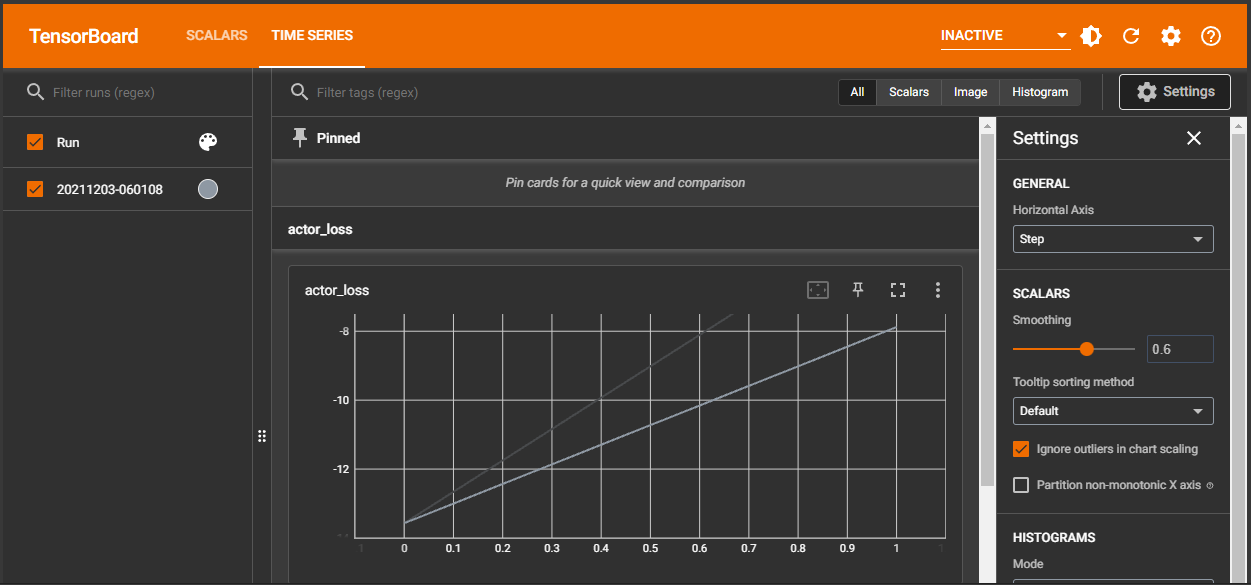

---

In [ ]:
!pip install -q watermark
%reload_ext watermark
%watermark -a "Sparsh A." -m -iv -u -t -d -p selenium

Author: Sparsh A.

Last updated: 2021-12-03 06:04:00

selenium: 4.1.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

gym       : 0.17.3
sys       : 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
tensorflow: 2.7.0
numpy     : 1.19.5
argparse  : 1.1
IPython   : 5.5.0



---

**END**